# Second exploration of the Kv2.1 data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
from analysis_helpers import *

Let's first recap, in compact form and with usable outputs, the first exploration. To skip down to the exploratory bits in this file, [click here](#Second-exploration-begins)

In [2]:
filebase = '/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf'
fileno, fileno2 = 9,10
savebase = filebase[:-4] % fileno + '-' + str(fileno2)
params = dict()
tres = 0.025 # Time of one sample in ms

Notes tell me that until 2017-12-06_0018, the current scale was set incorrectly, such that one unit of current in the file corresponds to 2 μA. We can fix that right here:

In [3]:
rec = read_2channel_ATF(filebase % fileno, current_factor = 0.5)
rec2 = read_2channel_ATF(filebase % (fileno2), current_factor = 0.5)

To make sure we've got the right recordings, let's visualise the full trace stacks:

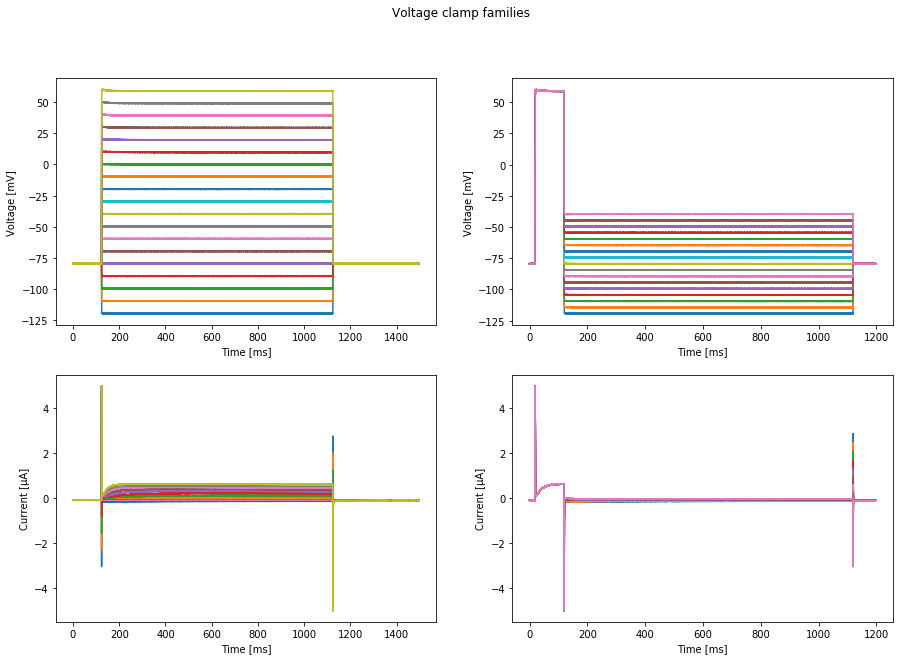

In [4]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Voltage clamp families')

t = np.arange(len(rec.voltage[0])) * tres
t2 = np.arange(len(rec2.voltage[0])) * tres

plt.subplot(2,2,1)
for V in rec.voltage:
    plt.plot(t, V)
plt.ylabel('Voltage [mV]')
plt.xlabel('Time [ms]')

plt.subplot(2,2,2)
for V in rec2.voltage:
    plt.plot(t2, V)
plt.ylabel('Voltage [mV]')
plt.xlabel('Time [ms]')

plt.subplot(2,2,3)
for I in rec.current:
    plt.plot(t, I)
plt.ylabel(u'Current [μA]')
plt.xlabel('Time [ms]')

plt.subplot(2,2,4)
for I in rec2.current:
    plt.plot(t2, I)
plt.ylabel(u'Current [μA]')
plt.xlabel('Time [ms]');

fig.savefig(savebase + '.family.png')

Then, fit the leak current to the first family by looking at the lower end of the steps:

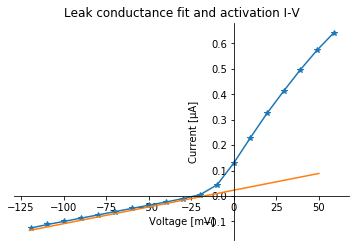

In [5]:
# The start and end of the step, with some room for the capacitive current to dissipate:
rec_limits = (5200, 44800)

fig, ax = plt.subplots()
fit_leak(rec, params, ax, rec_limits)

plt.title('Leak conductance fit and activation I-V')
plt.savefig(savebase + '.leak_IV.png')

Next, fit the potassium conductance to the tail currents of the second protocol:

In [6]:
rec2_limits = (4750, 10000)
fit_tails(rec2, rec2_limits[0], rec2_limits[1], baseline = [np.median(I[40000:44000]) for I in rec2.current])

analysis_helpers.py:94: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-t / tau)
analysis_helpers.py:94: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-t / tau)


([5981.899137695004,
  5863.378426094768,
  5714.299653917621,
  5475.930899899878,
  5225.944290565168,
  4911.429496497379,
  4587.4033637074135,
  4390.61259405022,
  4159.274095091137,
  4539.088146848965,
  11092.101906687334,
  2930439040.8806334,
  600.3903324396649,
  850.3431114606436,
  1005.0401045625628,
  1226.6052183951274,
  1507.0697635254908],
 [-0.02423937600261822,
  -0.021834108533526568,
  -0.019432648171598545,
  -0.017390513676971475,
  -0.015472319277033636,
  -0.013518308943912604,
  -0.01173033269645068,
  -0.009898917838997798,
  -0.007690648329000234,
  -0.005123694515562989,
  -0.0019712047376466736,
  -0.00017365323881036974,
  0.016469012805582172,
  0.024585448548750367,
  0.03523417083232943,
  0.046267105073140816,
  0.05843877962073171])

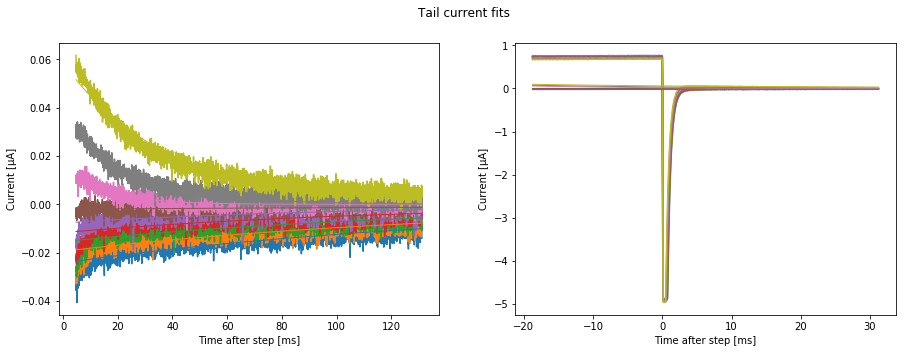

In [7]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plot_tail_fit(rec2, params, rec2.tail_cut, 10000, tres, range(0, len(rec2.tails), 2))

plt.subplot(1,2,2)
plot_tail_fit(rec2, params, 4000, 6000, tres, range(0, len(rec2.tails), 2))

fig.suptitle('Tail current fits')
fig.savefig(savebase + '.tail_fits.png')

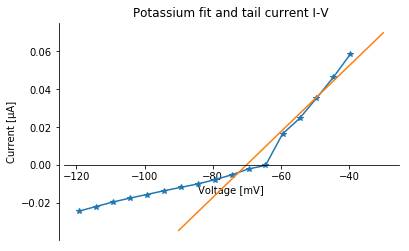

In [8]:
tail_t0 = [exp_decay(0, rec2.tau[i], rec2.a[i]) for i in range(len(rec2.tails))]

fig, ax = plt.subplots()
IVplot(tail_t0, rec2.tail_voltages, ax)

tail_fit_from = np.count_nonzero(map(lambda V: V < -80, rec2.tail_voltages))
fit_IV(tail_t0[tail_fit_from:], rec2.tail_voltages[tail_fit_from:], params, 'K')

tail_plot_V = np.array([-90, -30])
ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

ax.set_title('Potassium fit and tail current I-V')
plt.savefig(savebase + '.tail_IV.png')

So, we have a valid, sensible E_K.
# Second exploration begins
Let's go back to the first protocol and turn that I-V into an activation curve!

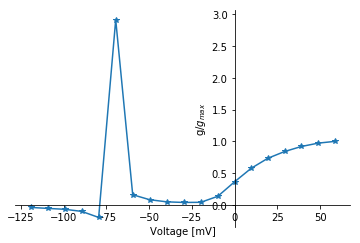

In [9]:
median_voltages = [np.median(V[rec_limits[0]:rec_limits[1]]) for V in rec.voltage]
peak_currents = [np.max(rec.current[i][rec_limits[0]:rec_limits[1]]) - params['I_leak'](median_voltages[i])
                 for i in range(len(rec.current))]

gK = [peak_currents[i] / (median_voltages[i] - params['E_K']) for i in range(len(peak_currents))]
positive_V = np.count_nonzero(map(lambda V: V>0, median_voltages))
gMax = max(gK[-positive_V:])
g_norm = np.array(gK) / gMax

fig, ax = plt.subplots()
IVplot(g_norm, median_voltages, ax, Ilabel='g/$g_{max}$')

The kinks near E_K are an artifact of noise, of course. What's striking about the shape is that it doesn't seem to fully activate until well over 50 mV!
This isn't quite the activation curve I'd like to see yet, however: after all, I'd like to see the activation variable, not the conductance. To get that, we assume that the peak current in each trace is 95% of the steady-state current defined by
$$I_{\infty}(V) = \bar{g} n_{\infty}^4(V) (V-E_K); I_{max} = 0.95 I_{\infty}$$
and that $g_{max} = 0.95 \bar{g}$, which gives
$$n_\infty^4(V) = \frac {I_{\infty}(V)} {\bar{g} (V-E_K)} = \frac {I_{max}(V)} {g_{max} (V-E_K)}$$

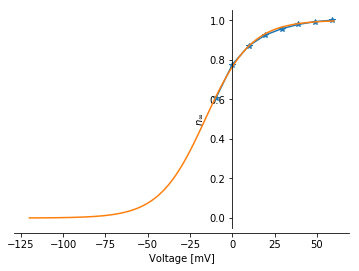

In [10]:
# Only show the top end, where g/gmax > 10% -- below that, it gets noisy and messy, because peaks aren't
# reliably detectable any longer.
for i in range(len(g_norm)):
    if g_norm[-i-1] < 0.1:
        break
min_peak = len(g_norm) - i
n_inf = np.power(g_norm[min_peak:], 0.25)

# Plot n_inf
fig, ax = plt.subplots()
IVplot(n_inf, median_voltages[min_peak:], ax, Ilabel='$n_{\\infty}$')

# Fit a sigmoid
def sigmoid(x, Vhalf, Vslope):
    return 1/(1 + np.exp((x - Vhalf)/ Vslope))
p, cov = scipy.optimize.curve_fit(sigmoid, median_voltages[min_peak:], n_inf, [-25., -1.])

# Show it
V = np.linspace(-120, 60, 100)
ax.plot(V, sigmoid(V, p[0], p[1]));

# Save it
params['nK_mid'] = p[0]
params['nK_slope'] = p[1]

Now that is a nice (top half of a) sigmoid, and a great fit! Maybe we can also fit tau. Let's check the time to peak first:

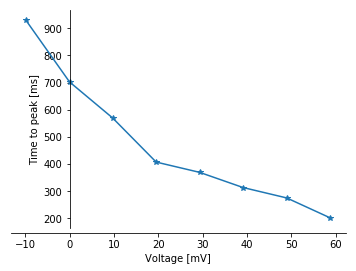

In [11]:
t0 = 4937 # Beginning of step, see rec_step_t0 in Kv2.1 exploratory analysis 1
peak_current_idx = [(np.argmax(I[rec_limits[0]:rec_limits[1]]) + rec_limits[0]) for I in rec.current]
peak_current_t = tres * (np.array(peak_current_idx) - t0)

fig, ax = plt.subplots()
IVplot(peak_current_t[min_peak:], median_voltages[min_peak:], ax, Ilabel='Time to peak [ms]')

That looks reasonable, but time to peak isn't tau!

The activation variable $n$ follows the differential equation
$$\frac{dn}{dt} = \frac{n_\infty - n}{\tau}$$
which, assuming a fixed voltage, can be solved as
$$n = n_\infty - (n_\infty - n_0) exp(\frac{-t}{\tau})$$
We can estimate $n_0$, the value of $n$ at $t = 0$, from the sigmoid fit, or assume 0, which should be close enough, and $n_\infty$ likewise from the sigmoid. We can then fit the current equation to the traces between the step and the peak:
$$I(t) = \bar{g} n_V^4(t) (V-E_K)$$

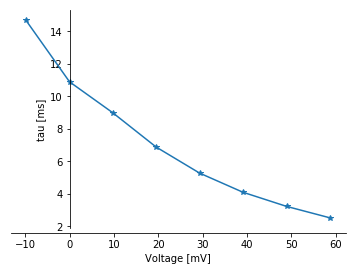

In [12]:
def current_fn(V, n0, params):
    ninf = sigmoid(V, params['nK_mid'], params['nK_slope'])
    gbar = params['g_K']
    EK = params['E_K']
    def fn(t, tau):
        n = ninf - (ninf - n0) * np.exp(-t/tau)
        n = np.clip(n, 0, 1)
        return gbar * n**4 * (V-EK)
    return fn

tau = [0]*len(rec.voltage)
for i in range(min_peak, len(rec.voltage)):
    data = rec.current[i][rec_limits[0] : peak_current_idx[i]+1] # current from safe cutoff to maximum
    time = tres * (np.arange(rec_limits[0], peak_current_idx[i]+1) - t0) # ms since step
    p, cov = scipy.optimize.curve_fit(current_fn(median_voltages[i], 0, params), time, data)
    tau[i] = p[0]

fig, ax = plt.subplots()
IVplot(tau[min_peak:], median_voltages[min_peak:], ax, Ilabel='tau [ms]')

Of course, we'd like to extend this to the left. While we don't have good activation values there, we can instead use the tail currents from the second protocol. Here, we can assume $n_0 = 1$, and again estimate the $n_\infty$ from the sigmoid.

/usr/lib64/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


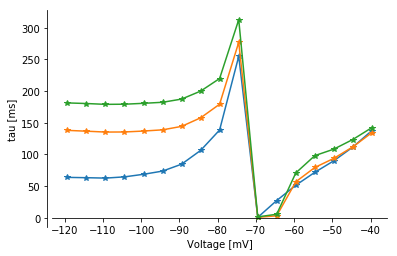

In [13]:
fig, ax = plt.subplots()
tau2 = []

for offset in (0, 1000, 2000):
    tau2.append([0]*len(rec2.tails))
    for i in range(len(rec2.tails)):
        data = rec2.tails[i][offset:]
        time = tres * (np.arange(rec2.tail_cut+offset, rec2_limits[1]) - rec2_limits[0]) # ms since step
        p, cov = scipy.optimize.curve_fit(current_fn(rec2.tail_voltages[i], 1, params), time, data,
                                          [tau2[-1][i-1]] if i > 0 and tau2[-1][i-1]>5 else [100.])
        tau2[-1][i] = p[0]

    IVplot(tau2[-1], rec2.tail_voltages, ax, Ilabel='tau [ms]')

Hmm. I'm not sure which values to trust most here!
* The high-voltage ones are least contaminated with capacitance effects, but may contain some slow inactivation. The latter would seem to be largely irrelevant, but I'm noting it for completeness.
* The low-voltage fits are likely to contain some capacitance spike decay, which goes in the same direction (for $V < E_K$) and is larger, the lower the voltage. This effect is mitigated by moving the tail_cut away from the step, but that so grossly affects the values seen, and enhances the central discontinuity, that I'm unsure that's the right thing to do.
* The fits in the middle, which look very broken, may be wrong due to misestimation of $E_K$, as well as because the tail currents here are almost perfectly flat. Perhaps we may disregard the discontinuity for this reason?

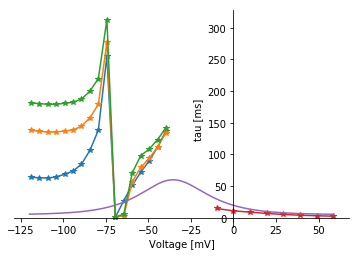

In [14]:
fig, ax = plt.subplots()

for tmp in tau2:
    IVplot(tmp, rec2.tail_voltages, ax)

IVplot(tau[min_peak:], median_voltages[min_peak:], ax)

def tau_modelled(V):
    tau_min = 5.
    tau_max = 110.
    tau_off = 36.
    tau_slope1 = 18.
    tau_slope2 = -17.
    return tau_min + tau_max/(np.exp((tau_off+V)/tau_slope1) + np.exp((tau_off+V)/tau_slope2))

Vprobe = np.arange(-120,60)
IVplot(tau_modelled(Vprobe), Vprobe, ax, style='-', Ilabel='tau [ms]')

In [15]:
print filebase % fileno
print filebase % fileno2
print savebase
print 'g_leak:\t', params['g_leak'], 'mS'
print 'E_leak:\t', params['E_leak'], 'mV'
print 'g_K:\t', params['g_K'], 'mS'
print 'E_K:\t', params['E_K'], 'mV'
print 'nK_mid:\t', params['nK_mid'], 'mV'
print 'nK_slope:\t', params['nK_slope'], 'mV'
print

/home/kernfel/Documents/Data/Oocytes/2017_12_06_0009.atf
/home/kernfel/Documents/Data/Oocytes/2017_12_06_0010.atf
/home/kernfel/Documents/Data/Oocytes/2017_12_06_0009-10
g_leak:	0.0013171991933835095 mS
E_leak:	-17.184929634892253 mV
g_K:	0.0017356941931743004 mS
E_K:	-70.18556823673305 mV
nK_mid:	-15.979014691709166 mV
nK_slope:	-13.571796748286623 mV



## Rectification
Looking at the tail current I-Vs of a number of recordings shows very clearly that this channel is heavily rectifying. What this implies is that assuming a single $\bar{g}$ for both positive and negative currents is actually invalid. To see this, one needs only compare the slopes at the left and right sides of the tail current I-V:

-70.18556823673305 0.0017356941931743004
-60.940518121140194 0.0004079767243359119


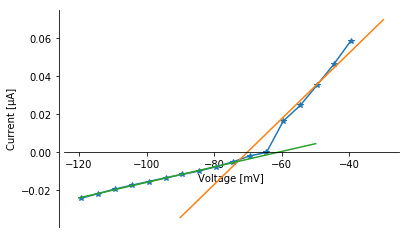

In [19]:
tail_t0 = [exp_decay(0, rec2.tau[i], rec2.a[i]) for i in range(len(rec2.tails))]

fig, ax = plt.subplots()
IVplot(tail_t0, rec2.tail_voltages, ax)

tail_fit_from = np.count_nonzero(map(lambda V: V < -80, rec2.tail_voltages))
fit_IV(tail_t0[tail_fit_from:], rec2.tail_voltages[tail_fit_from:], params, 'K')
fit_IV(tail_t0[:tail_fit_from], rec2.tail_voltages[:tail_fit_from], params, 'Kr')

tail_plot_V = np.array([-90, -30])
ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

tail_plot_V = np.array([-120, -50])
ax.plot(tail_plot_V, params['I_Kr'](tail_plot_V))

print params['E_K'], params['g_K']
print params['E_Kr'], params['g_Kr']

There are several things to note here:
* If this channel did not rectify, the primary artifact in play -- namely, the remaining capacitive current at the tail cutoff -- would tend to make the tail current more negative, i.e. increase the g_Kr slope and decrease the g_K slope, not vice versa
* The discrepant equilibrium fit poses a bit of a problem
* Not all recordings provide a sensible Kr fit, and the switch between low-conductance and high-conductance state isn't always at the equilibrium potential (see 2017_06_12_0000 for a very clear example)

Would fitting tau in the low-conductance parts to the rectifying parameters make a difference?

In [21]:
def current_fn_rect(V, n0, params):
    ninf = sigmoid(V, params['nK_mid'], params['nK_slope'])
    gbar = params['g_Kr']
    EK = params['E_Kr']
    def fn(t, tau):
        n = ninf - (ninf - n0) * np.exp(-t/tau)
        n = np.clip(n, 0, 1)
        return gbar * n**4 * (V-EK)
    return fn

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


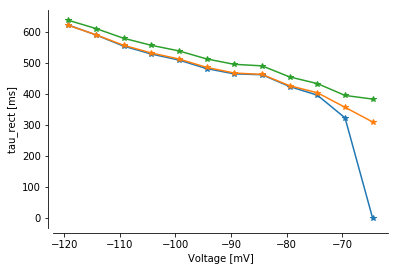

In [23]:
fig, ax = plt.subplots()
tau_rect = []

# Rectified currents only
for i in range(len(tail_t0)):
    if tail_t0[i] > 0:
        break
n_rect = i

for offset in (0, 1000, 2000):
    tau_rect.append([0]*n_rect)
    for i in range(n_rect):
        data = rec2.tails[i][offset:]
        time = tres * (np.arange(rec2.tail_cut+offset, rec2_limits[1]) - rec2_limits[0]) # ms since step
        p, cov = scipy.optimize.curve_fit(current_fn_rect(rec2.tail_voltages[i], 1, params), time, data,
                                          [tau_rect[-1][i-1]] if i > 0 and tau_rect[-1][i-1]>5 else [100.])
        tau_rect[-1][i] = p[0]

    IVplot(tau_rect[-1], rec2.tail_voltages[:n_rect], ax, Ilabel='tau_rect [ms]')

How interesting, the discrepancy from using different cutoffs is practically gone - which means, it was an artifact not of the capacitive current, but of rectification!

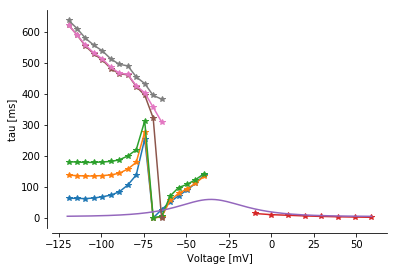

In [24]:
fig, ax = plt.subplots()

for tmp in tau2:
    IVplot(tmp, rec2.tail_voltages, ax)

IVplot(tau[min_peak:], median_voltages[min_peak:], ax)

def tau_modelled(V):
    tau_min = 5.
    tau_max = 110.
    tau_off = 36.
    tau_slope1 = 18.
    tau_slope2 = -17.
    return tau_min + tau_max/(np.exp((tau_off+V)/tau_slope1) + np.exp((tau_off+V)/tau_slope2))

Vprobe = np.arange(-120,60)
IVplot(tau_modelled(Vprobe), Vprobe, ax, style='-', Ilabel='tau [ms]')

for tmp in tau_rect:
    IVplot(tmp, rec2.tail_voltages[:n_rect], ax, Ilabel='tau [ms]')

But obviously, I'd now have to have two separate taus - one for rectified/positive current (easy enough, a linear slope'll do -- no positive current can occur at $V>E_K$) and one for normal/negative current. Is that worth the effort?